In [20]:
# =============================================
# 1. IMPORTS & DATA LOADING
# =============================================

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("../data/Initial Engagement v1 - _WITH_videos_AS_get_the_videos_.csv")  # Adjust to your actual file path

print("Shape of data:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Shape of data: (18468, 18)
Columns: ['video_id', 'video_published_timestamp', 'channel_id', 'channel_name', 'creator_type_id', 'video_length', 'views_final', 'impressions_final', 'like_final', 'comment_final', 'views3s_1k', 'impressions_1k', 'like_1k', 'comments_1k', 'views3s_5k', 'impressions_5k', 'like_5k', 'comments_5k']


,video_id,video_published_timestamp,channel_id,channel_name,creator_type_id,video_length,views_final,impressions_final,like_final,comment_final,views3s_1k,impressions_1k,like_1k,comments_1k,views3s_5k,impressions_5k,like_5k,comments_5k
0,1003293784462230,3/15/24 21:45,100474954808558,BruhmanTv,CP Medium,486,1186.0,2937.0,17.0,8.0,360,1000,9.0,4.0,NaN,NaN,NaN,NaN
1,1006175824494570,3/8/24 22:01,1766091956951910,Amazing Gaming,JSO,359,994.0,3027.0,1.0,NaN,293,1124,NaN,NaN,NaN,NaN,NaN,NaN
2,1007480763650670,1/10/24 21:00,110554014442388,Bratterstein,CP Medium,785,60904.0,96520.0,1094.0,51.0,593,1160,23.0,3.0,4002.0,6710.0,127.0,11.0
3,1007620776996620,1/4/24 17:10,103327818996077,House of Bounce - France,JSO,209,10085.0,18922.0,326.0,1.0,366,2115,48.0,NaN,2546.0,5346.0,99.0,NaN
4,1009999323413070,1/2/24 16:30,149245572393056,Soccer Stories,JSO,412,130986.0,286634.0,760.0,116.0,9471,39359,185.0,7.0,9471.0,39359.0,185.0,7.0


In [ ]:
# =============================================
# 2. HANDLE TIMESTAMP COLUMNS OR DROP THEM
# =============================================

# If 'video_published_timestamp' is present and is a string, parse it to datetime
if 'video_published_timestamp' in df.columns:
    try:
        df['video_published_timestamp'] = pd.to_datetime(
            df['video_published_timestamp'],
            errors='coerce'  # invalid parses become NaT
        )

        # Option 1: Extract numeric features (hour, weekday, etc.)
        df['publish_hour'] = df['video_published_timestamp'].dt.hour
        df['publish_weekday'] = df['video_published_timestamp'].dt.weekday
        df['publish_dayofyear'] = df['video_published_timestamp'].dt.dayofyear

        # Option 2: Drop the original column to avoid string issues
        df.drop('video_published_timestamp', axis=1, inplace=True)

        print("Timestamp column converted to numeric features: ['publish_hour', 'publish_weekday', 'publish_dayofyear']")
    except Exception as e:
        print("Error parsing video_published_timestamp, dropping column:", e)
        df.drop('video_published_timestamp', axis=1, inplace=True)

# If you have other string columns that are not relevant, you might drop them here:
# for col in ['some_other_column']:
#     df.drop(col, axis=1, inplace=True, errors='ignore')

print("Columns after timestamp handling:", df.columns.tolist())
df.head()

/var/folders/db/wvxvqb3n1x3g3lw6rkhn8zxh0000gn/T/ipykernel_68866/2648167360.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['video_published_timestamp'] = pd.to_datetime(


Timestamp column converted to numeric features: ['publish_hour', 'publish_weekday', 'publish_dayofyear']
Columns after timestamp handling: ['video_id', 'channel_id', 'channel_name', 'creator_type_id', 'video_length', 'views_final', 'impressions_final', 'like_final', 'comment_final', 'views3s_1k', 'impressions_1k', 'like_1k', 'comments_1k', 'views3s_5k', 'impressions_5k', 'like_5k', 'comments_5k', 'publish_hour', 'publish_weekday', 'publish_dayofyear']


,video_id,channel_id,channel_name,creator_type_id,video_length,views_final,impressions_final,like_final,comment_final,views3s_1k,impressions_1k,like_1k,comments_1k,views3s_5k,impressions_5k,like_5k,comments_5k,publish_hour,publish_weekday,publish_dayofyear
0,1003293784462230,100474954808558,BruhmanTv,CP Medium,486,1186.0,2937.0,17.0,8.0,360,1000,9.0,4.0,NaN,NaN,NaN,NaN,21,4,75
1,1006175824494570,1766091956951910,Amazing Gaming,JSO,359,994.0,3027.0,1.0,NaN,293,1124,NaN,NaN,NaN,NaN,NaN,NaN,22,4,68
2,1007480763650670,110554014442388,Bratterstein,CP Medium,785,60904.0,96520.0,1094.0,51.0,593,1160,23.0,3.0,4002.0,6710.0,127.0,11.0,21,2,10
3,1007620776996620,103327818996077,House of Bounce - France,JSO,209,10085.0,18922.0,326.0,1.0,366,2115,48.0,NaN,2546.0,5346.0,99.0,NaN,17,3,4
4,1009999323413070,149245572393056,Soccer Stories,JSO,412,130986.0,286634.0,760.0,116.0,9471,39359,185.0,7.0,9471.0,39359.0,185.0,7.0,16,1,2


In [22]:
# =============================================
# 3. DROP ANY *_final COLUMNS EXCEPT 'views_final'
# =============================================

cols_to_drop = []
for col in df.columns:
    if col.endswith("_final") and col != "views_final":
        cols_to_drop.append(col)

if len(cols_to_drop) > 0:
    print("Dropping final columns:", cols_to_drop)
    df.drop(columns=cols_to_drop, inplace=True)

print("Columns after dropping final metrics:", df.columns.tolist())
df.head()

Dropping final columns: ['impressions_final', 'like_final', 'comment_final']
Columns after dropping final metrics: ['video_id', 'channel_id', 'channel_name', 'creator_type_id', 'video_length', 'views_final', 'views3s_1k', 'impressions_1k', 'like_1k', 'comments_1k', 'views3s_5k', 'impressions_5k', 'like_5k', 'comments_5k', 'publish_hour', 'publish_weekday', 'publish_dayofyear']


,video_id,channel_id,channel_name,creator_type_id,video_length,views_final,views3s_1k,impressions_1k,like_1k,comments_1k,views3s_5k,impressions_5k,like_5k,comments_5k,publish_hour,publish_weekday,publish_dayofyear
0,1003293784462230,100474954808558,BruhmanTv,CP Medium,486,1186.0,360,1000,9.0,4.0,NaN,NaN,NaN,NaN,21,4,75
1,1006175824494570,1766091956951910,Amazing Gaming,JSO,359,994.0,293,1124,NaN,NaN,NaN,NaN,NaN,NaN,22,4,68
2,1007480763650670,110554014442388,Bratterstein,CP Medium,785,60904.0,593,1160,23.0,3.0,4002.0,6710.0,127.0,11.0,21,2,10
3,1007620776996620,103327818996077,House of Bounce - France,JSO,209,10085.0,366,2115,48.0,NaN,2546.0,5346.0,99.0,NaN,17,3,4
4,1009999323413070,149245572393056,Soccer Stories,JSO,412,130986.0,9471,39359,185.0,7.0,9471.0,39359.0,185.0,7.0,16,1,2


In [23]:
# =============================================
# 4. FEATURE ENGINEERING
# =============================================

# Replace 0 with NaN in impression/view columns to avoid dividing by zero
df['impressions_1k'] = df['impressions_1k'].replace(0, np.nan)
df['views3s_1k'] = df['views3s_1k'].replace(0, np.nan)

# Basic 1K features
df['ctr_1k'] = df['views3s_1k'] / df['impressions_1k']
df['like_per_view_1k'] = df['like_1k'] / df['views3s_1k']
df['comment_per_view_1k'] = df['comments_1k'] / df['views3s_1k']

# Mark whether 5K data is available
df['has_5k_data'] = (~df['views3s_5k'].isna()) & (~df['impressions_5k'].isna())
df['has_5k_data'] = df['has_5k_data'].astype(int)

mask_5k = (df['has_5k_data'] == 1)

# 5K features
df.loc[mask_5k, 'ctr_5k'] = df.loc[mask_5k, 'views3s_5k'] / df.loc[mask_5k, 'impressions_5k'].replace(0, np.nan)
df.loc[mask_5k, 'like_per_view_5k'] = df.loc[mask_5k, 'like_5k'] / df.loc[mask_5k, 'views3s_5k'].replace(0, np.nan)
df.loc[mask_5k, 'comment_per_view_5k'] = df.loc[mask_5k, 'comments_5k'] / df.loc[mask_5k, 'views3s_5k'].replace(0, np.nan)

df.loc[mask_5k, 'view_growth_rate'] = \
    (df.loc[mask_5k, 'views3s_5k'] - df.loc[mask_5k, 'views3s_1k']) / df.loc[mask_5k, 'views3s_1k']

df.loc[mask_5k, 'impression_growth_rate'] = \
    (df.loc[mask_5k, 'impressions_5k'] - df.loc[mask_5k, 'impressions_1k']) / df.loc[mask_5k, 'impressions_1k']

# Example: if there's video_length, bin it
if 'video_length' in df.columns:
    df['video_length_bin'] = pd.cut(df['video_length'],
                                    bins=[0, 60, 180, 300, 600, np.inf],
                                    labels=['very_short','short','medium','long','very_long'])
    df = pd.get_dummies(df, columns=['video_length_bin'], drop_first=True)

# Example: if there's a creator_type_id or category, one-hot encode it
if 'creator_type_id' in df.columns:
    df = pd.get_dummies(df, columns=['creator_type_id'], drop_first=True)

# Fill any leftover NaN
df = df.fillna(0)

print("Columns after feature engineering:", df.columns.tolist())
df.head()

Columns after feature engineering: ['video_id', 'channel_id', 'channel_name', 'video_length', 'views_final', 'views3s_1k', 'impressions_1k', 'like_1k', 'comments_1k', 'views3s_5k', 'impressions_5k', 'like_5k', 'comments_5k', 'publish_hour', 'publish_weekday', 'publish_dayofyear', 'ctr_1k', 'like_per_view_1k', 'comment_per_view_1k', 'has_5k_data', 'ctr_5k', 'like_per_view_5k', 'comment_per_view_5k', 'view_growth_rate', 'impression_growth_rate', 'video_length_bin_short', 'video_length_bin_medium', 'video_length_bin_long', 'video_length_bin_very_long', 'creator_type_id_CP Medium', 'creator_type_id_CP Standard', 'creator_type_id_JSO']


,video_id,channel_id,channel_name,video_length,views_final,views3s_1k,impressions_1k,like_1k,comments_1k,views3s_5k,...,comment_per_view_5k,view_growth_rate,impression_growth_rate,video_length_bin_short,video_length_bin_medium,video_length_bin_long,video_length_bin_very_long,creator_type_id_CP Medium,creator_type_id_CP Standard,creator_type_id_JSO
0,1003293784462230,100474954808558,BruhmanTv,486,1186.0,360.0,1000,9.0,4.0,0.0,...,0.000000,0.000000,0.000000,False,False,True,False,True,False,False
1,1006175824494570,1766091956951910,Amazing Gaming,359,994.0,293.0,1124,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,False,False,True,False,False,False,True
2,1007480763650670,110554014442388,Bratterstein,785,60904.0,593.0,1160,23.0,3.0,4002.0,...,0.002749,5.748735,4.784483,False,False,False,True,True,False,False
3,1007620776996620,103327818996077,House of Bounce - France,209,10085.0,366.0,2115,48.0,0.0,2546.0,...,0.000000,5.956284,1.527660,False,True,False,False,False,False,True
4,1009999323413070,149245572393056,Soccer Stories,412,130986.0,9471.0,39359,185.0,7.0,9471.0,...,0.000739,0.000000,0.000000,False,False,True,False,False,False,True


In [24]:
# =============================================
# 5. LIFETIME CLASS DERIVATION
# =============================================

df['lifetime_class'] = 0

mask_5k_data = (df['has_5k_data'] == 1) & (df['view_growth_rate'] != 0)
df_5k_only = df.loc[mask_5k_data].copy()

if len(df_5k_only) > 0:
    df_5k_only['lifetime_class'] = pd.qcut(df_5k_only['view_growth_rate'], q=4, labels=[1,2,3,4]).astype(int)
    df.loc[mask_5k_data, 'lifetime_class'] = df_5k_only['lifetime_class']

mask_1k_only = (df['has_5k_data'] == 0)

# If there's enough 5k data to train a small classifier
if mask_1k_only.sum() > 0 and len(df_5k_only) > 0:
    features_for_classif = ['ctr_1k','like_per_view_1k','comment_per_view_1k']
    df_train_cls = df_5k_only.dropna(subset=features_for_classif + ['lifetime_class'])

    X_train_cls = df_train_cls[features_for_classif]
    y_train_cls = df_train_cls['lifetime_class']

    clf = RandomForestClassifier(n_estimators=50, random_state=42)
    clf.fit(X_train_cls, y_train_cls)

    df_1k_only = df.loc[mask_1k_only].copy()
    X_pred_cls = df_1k_only[features_for_classif]
    predicted_lc = clf.predict(X_pred_cls)
    df.loc[mask_1k_only, 'lifetime_class'] = predicted_lc

print("Lifetime class distribution:")
print(df['lifetime_class'].value_counts())

Lifetime class distribution:
lifetime_class
0    4943
3    3604
4    3496
2    3220
1    3205
Name: count, dtype: int64


In [25]:
# =============================================
# 6. PREP FOR REGRESSION (DROPPING NON-NUMERIC)
# =============================================

# Our target is views_final
target_col = "views_final"
if target_col not in df.columns:
    raise ValueError("views_final not in dataset. Adjust target column.")

# Identify columns we do NOT want in our features
excluded_cols = [
    "video_id",       # if present
    "lifetime_class", # used for grouping, not a numeric predictor
    target_col,       # our label, not a feature
]

# We'll remove them from the feature set
feature_cols = [c for c in df.columns if c not in excluded_cols]

# Ensure all remaining columns are numeric
df_numeric = df[feature_cols].copy()

# If any columns are still non-numeric, convert or drop them
for col in df_numeric.columns:
    if df_numeric[col].dtype == 'object':
        # If we can't parse them, drop or handle them
        print(f"Dropping non-numeric column '{col}' from features.")
        df_numeric.drop(col, axis=1, inplace=True)

X_full = df_numeric
y_full = df[target_col]
lc_full = df['lifetime_class']

Dropping non-numeric column 'channel_name' from features.


In [26]:
# =============================================
# 7. TRAIN/TEST SPLIT & SPECIALIZED MODEL TRAINING
# =============================================

X_train, X_test, y_train, y_test, lc_train, lc_test = train_test_split(
    X_full, y_full, lc_full, test_size=0.2, random_state=42
)

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
}

specialized_models = {}
unique_lcs = lc_train.unique()

for lc in unique_lcs:
    mask_lc = (lc_train == lc)
    if mask_lc.sum() < 10:
        # Not enough samples to do a big search
        quick_model = GradientBoostingRegressor(random_state=42)
        quick_model.fit(X_train[mask_lc], y_train[mask_lc])
        specialized_models[lc] = quick_model
        continue

    base_model = GradientBoostingRegressor(random_state=42)
    gs = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        cv=3,
        n_jobs=-1,
        scoring='neg_mean_absolute_percentage_error'
    )
    gs.fit(X_train[mask_lc], y_train[mask_lc])
    specialized_models[lc] = gs.best_estimator_
    print(f"Lifetime class {lc}, best params: {gs.best_params_}")

# Fallback model on all data
fallback_model = GradientBoostingRegressor(random_state=42)
fallback_model.fit(X_train, y_train)
specialized_models['fallback'] = fallback_model

Lifetime class 0, best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
Lifetime class 4, best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Lifetime class 2, best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Lifetime class 1, best params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
Lifetime class 3, best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}


/Users/adviti/code/advitis/video-performance-predictor/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/Users/adviti/code/advitis/video-performance-predictor/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/Users/adviti/code/advitis/video-performance-predictor/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/Users/adviti/code/advitis/video-performance-predictor/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.wa

Test MAPE: 133.3385  (i.e. 13333.85%)
Test R^2:  -0.1794


/Users/adviti/code/advitis/video-performance-predictor/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/Users/adviti/code/advitis/video-performance-predictor/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/Users/adviti/code/advitis/video-performance-predictor/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/Users/adviti/code/advitis/video-performance-predictor/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.wa

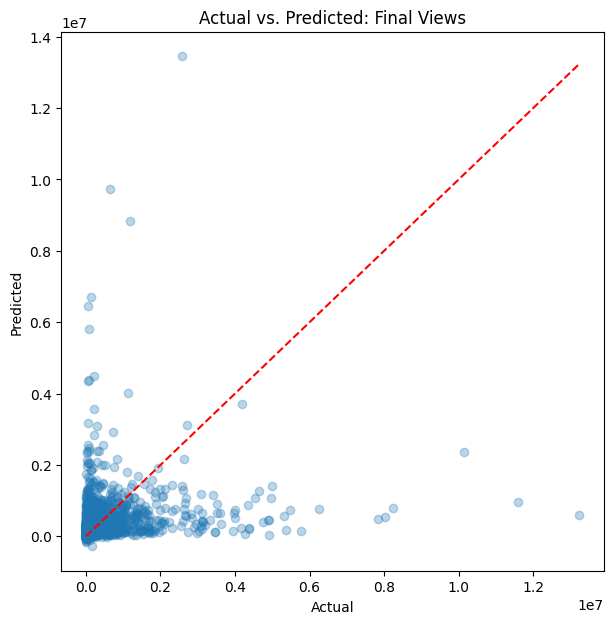

In [27]:
# =============================================
# 8. PREDICT & EVALUATE
# =============================================

y_pred = np.zeros(len(X_test))

for i, idx in enumerate(X_test.index):
    this_lc = lc_test.loc[idx]
    if this_lc in specialized_models:
        model = specialized_models[this_lc]
    else:
        model = specialized_models['fallback']

    row_feats = X_test.loc[idx].values.reshape(1, -1)
    y_pred[i] = model.predict(row_feats)[0]

mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MAPE: {mape:.4f}  (i.e. {mape*100:.2f}%)")
print(f"Test R^2:  {r2:.4f}")

plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()], 'r--')
plt.title("Actual vs. Predicted: Final Views")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()